# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times and durations of hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import h5py

import gpx_stats
import utils

print(tf.__version__)

2021-10-03 18:38:19.890607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.1


### Load data

Load the dataset that was prepared by running the following command in a shell:

`run prepareData.py '~/GPX-Tracks' 'Wandern'`

In [2]:
train_dataset_file = 'hiking_data_training.hdf5'
test_dataset_file = 'hiking_data_test.hdf5'

Convert data to a pandas dataframe:

In [3]:
def read_hdf5_to_dict(file_name):
    hdf5_data = h5py.File(file_name, 'r')
    hdf5_data_dict = {}
    for name in gpx_stats.GpxSegmentStats.get_header():
        if name == 'Path':
            hdf5_data_dict[name] = [gpx_stats.PathFeature(data) for data in hdf5_data[name]]
        else:
            hdf5_data_dict[name] = hdf5_data[name][...]

    hdf5_data.close()
    return hdf5_data_dict

train_hdf5_data_dict = read_hdf5_to_dict(train_dataset_file)
test_hdf5_data_dict = read_hdf5_to_dict(test_dataset_file)

path_features_shape = train_hdf5_data_dict['Path'][0].shape
    
train_dataset = pd.DataFrame.from_dict(train_hdf5_data_dict)
test_dataset = pd.DataFrame.from_dict(test_hdf5_data_dict)

train_dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill,Path
8440,83.588441,86.214619,172.0,172.0,0.0,0.000000,19.199992,<gpx_stats.PathFeature object at 0x7f5b5cb8c5b0>
8441,80.728736,81.541295,89.0,89.0,0.0,11.266683,0.000000,<gpx_stats.PathFeature object at 0x7f5b5cb8c610>
8442,51.561229,54.318354,95.0,95.0,0.0,0.000000,16.533325,<gpx_stats.PathFeature object at 0x7f5b5cb8c670>
8443,56.531630,58.885615,66.0,68.0,0.0,0.000000,16.200000,<gpx_stats.PathFeature object at 0x7f5b5cb8c6d0>
8444,50.151807,50.153846,34.0,34.0,0.0,0.000000,0.200000,<gpx_stats.PathFeature object at 0x7f5b5cb8c730>


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the data set.

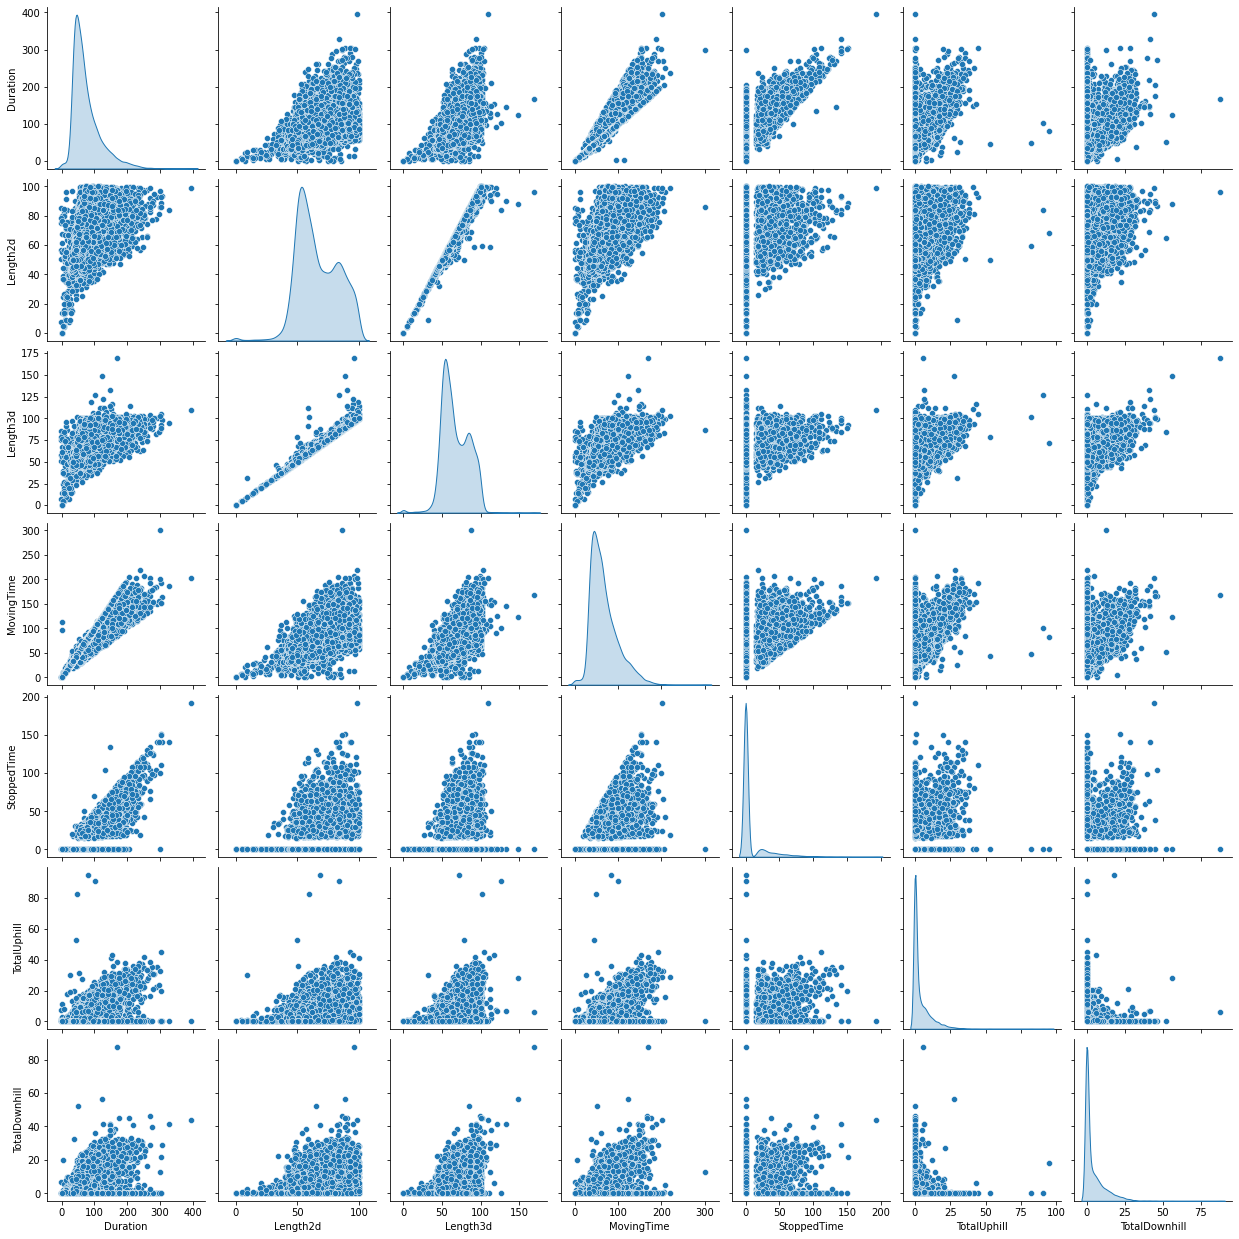

In [4]:
sns.pairplot(train_dataset[["Duration", "Length2d", "Length3d", "MovingTime", "StoppedTime", "TotalUphill", "TotalDownhill"]], diag_kind="kde")

These plots reveal that all features extracted from the GPX track segments show some correlation with the duration and moving time.

Also look at the overall statistics:

In [5]:
train_dataset_stats = train_dataset.describe()
train_dataset_stats.pop("MovingTime")
train_dataset_stats.pop("StoppedTime")
train_dataset_stats.pop("Duration")
train_dataset_stats = train_dataset_stats.transpose()
train_dataset_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,8445.0,66.100463,16.692782,0.0,53.211903,62.638144,80.128181,99.999114
Length3d,8445.0,67.187968,17.163922,0.0,54.014509,63.511057,81.502391,168.992541
TotalUphill,8445.0,3.971248,6.494668,0.0,0.000000,0.533366,5.806667,95.100000
TotalDownhill,8445.0,4.336326,6.698288,0.0,0.000000,0.750000,6.500000,87.693333


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [6]:
data_columns = ["Length2d", "Length3d", "TotalUphill", "TotalDownhill"]
path_columns = ["Path"]
label_columns = ['MovingTime']

train_data = train_dataset[data_columns]
train_labels = train_dataset[label_columns]

test_data = test_dataset[data_columns]
test_labels = test_dataset[label_columns]

In [7]:
train_paths_as_array = gpx_stats.convert_paths_to_array(train_dataset["Path"])
test_paths_as_array = gpx_stats.convert_paths_to_array(test_dataset["Path"])

Filter paths with `NaN` entries:

In [8]:
train_nan_mask = np.any(np.isnan(train_paths_as_array), axis=(1, 2))
test_nan_mask = np.any(np.isnan(test_paths_as_array), axis=(1, 2))

train_data = train_data[~train_nan_mask]
train_paths_as_array = train_paths_as_array[~train_nan_mask]
train_labels = train_labels[~train_nan_mask]

test_data = test_data[~test_nan_mask]
test_paths_as_array = test_paths_as_array[~test_nan_mask]
test_labels = test_labels[~test_nan_mask]

### Normalize the data

The statistics about `train_stats` in the above block shows a wide variation of ranges for all features. Although a model *might* converge without feature normalization, the latter usually improves convergence properties.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution as the one the model has been trained on.

In [9]:
def norm(x):
    return (x - train_dataset_stats['mean']) / train_dataset_stats['std']

normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

with open('train_dataset_stats.csv', 'w') as csvfile:
    train_dataset_stats.to_csv(csvfile, sep=' ')

`normed_train_data` is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model. This includes the test dataset as well as input during inference. Thus we need to save the normalization numbers together with the model.

## The model

### Build the model

Let's build our model. In this notebook, the architectures from the other two notebooks are combined: The statistical features are processed with fully-connected layers and the path features with LSTM layers. The resulting outputs are concatenated and processed with three more dense layers that finally output duration, moving time and stopped time. The model building steps are wrapped in a function, `build_model`, for convencience.

In [10]:
learning_rate = 0.001
batch_size = 256

def build_model():
    stat_inputs = layers.Input(shape=(normed_train_data.shape[1],), name='StatInput')
    stat_dense1 = layers.Dense(16, activation=tf.nn.relu)(stat_inputs)
    stat_dense2 = layers.Dense(16, activation=tf.nn.relu)(stat_dense1)
    stat_dense3 = layers.Dense(16, activation=tf.nn.relu)(stat_dense2)
    stat_dense4 = layers.Dense(16, activation=tf.nn.relu)(stat_dense3)
    
    path_inputs = layers.Input(shape=path_features_shape, name='PathInputs')
    conv1 = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation=tf.nn.relu)(path_inputs)
    conv2 = layers.Conv1D(filters=12, kernel_size=3, padding='same', activation=tf.nn.relu)(conv1)
    bn1 = layers.BatchNormalization()(conv2)
    conv3 = layers.Conv1D(filters=24, kernel_size=3, padding='same', activation=tf.nn.relu)(bn1)
    conv4 = layers.Conv1D(filters=6, kernel_size=3, padding='same', activation=tf.nn.relu)(conv3)
    bn2 = layers.BatchNormalization()(conv4)
    
    lstm1 = layers.LSTM(16, return_sequences=True)(bn2)
    dropout = layers.Dropout(0.25)(lstm1)
    lstm2 = layers.LSTM(16, return_sequences=False)(dropout)
    dropout2 = layers.Dropout(0.25)(lstm2)
    lstm_dense1 = layers.Dense(16, activation=tf.nn.relu)(dropout2)
    
    concat = layers.Concatenate()([stat_dense4, lstm_dense1])
    dense1 = layers.Dense(32, activation=tf.nn.relu)(concat)
    dense2 = layers.Dense(32, activation=tf.nn.relu)(dense1)
    
    outputs = layers.Dense(len(train_labels.keys()), activation=None)(dense2)
    
    model = models.Model(inputs=[stat_inputs, path_inputs], outputs=outputs)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

2021-10-03 18:38:26.120949: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-03 18:38:26.162644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 18:38:26.163238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.77GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-03 18:38:26.163271: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-03 18:38:26.165761: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-03 18:38:26.165820: I tensorflow/stream_executor/platform/de

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
PathInputs (InputLayer)         [(None, 25, 3)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 25, 6)        60          PathInputs[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 12)       228         conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25, 12)       48          conv1d_1[0][0]                   
______________________________________________________________________________________________


Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [12]:
example_batch = [normed_train_data[:4], train_paths_as_array[:4]]
example_result = model.predict(example_batch)
example_result

2021-10-03 18:38:26.954497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-03 18:38:26.973130: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593295000 Hz
2021-10-03 18:38:27.411222: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-03 18:38:27.708154: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-10-03 18:38:27.708370: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-03 18:38:28.008851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101


array([[-0.01929252],
       [-0.04212281],
       [-0.1356339 ],
       [-0.01084373]], dtype=float32)

### Train the model

Train the model for up to 500 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [13]:
EPOCHS = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=10, min_lr=0.01*learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                                                  restore_best_weights=True)

callbacks = [reduce_lr, early_stopping]


history = model.fit([normed_train_data, train_paths_as_array], 
                    train_labels.values,
                    epochs=EPOCHS, validation_split=0.2, verbose=1,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/500
27/27 [==============================] - 3s 33ms/step - loss: 5305.2231 - mean_absolute_error: 65.7574 - mean_squared_error: 5305.2231 - val_loss: 5179.7471 - val_mean_absolute_error: 64.6382 - val_mean_squared_error: 5179.7471
Epoch 2/500
27/27 [==============================] - 0s 12ms/step - loss: 4038.7493 - mean_absolute_error: 55.4889 - mean_squared_error: 4038.7493 - val_loss: 2978.9358 - val_mean_absolute_error: 45.6697 - val_mean_squared_error: 2978.9358
Epoch 3/500
27/27 [==============================] - 0s 12ms/step - loss: 1624.3885 - mean_absolute_error: 30.6389 - mean_squared_error: 1624.3885 - val_loss: 833.9530 - val_mean_absolute_error: 21.0250 - val_mean_squared_error: 833.9530
Epoch 4/500
27/27 [==============================] - 0s 12ms/step - loss: 558.9057 - mean_absolute_error: 17.1112 - mean_squared_error: 558.9057 - val_loss: 513.5394 - val_mean_absolute_error: 15.2521 - val_mean_squared_error: 513.5394
Epoch 5/500
27/27 [===========================

27/27 [==============================] - 0s 12ms/step - loss: 265.6069 - mean_absolute_error: 11.3215 - mean_squared_error: 265.6069 - val_loss: 296.5266 - val_mean_absolute_error: 11.7850 - val_mean_squared_error: 296.5266
Epoch 36/500
27/27 [==============================] - 0s 12ms/step - loss: 261.7267 - mean_absolute_error: 11.2818 - mean_squared_error: 261.7267 - val_loss: 297.2006 - val_mean_absolute_error: 11.7947 - val_mean_squared_error: 297.2006
Epoch 37/500
27/27 [==============================] - 0s 12ms/step - loss: 261.6852 - mean_absolute_error: 11.2575 - mean_squared_error: 261.6852 - val_loss: 316.4177 - val_mean_absolute_error: 11.8823 - val_mean_squared_error: 316.4177
Epoch 38/500
27/27 [==============================] - 0s 12ms/step - loss: 260.3214 - mean_absolute_error: 11.2514 - mean_squared_error: 260.3214 - val_loss: 305.0501 - val_mean_absolute_error: 11.7641 - val_mean_squared_error: 305.0501
Epoch 39/500
27/27 [==============================] - 0s 13ms/ste

Epoch 70/500
27/27 [==============================] - 0s 12ms/step - loss: 242.8421 - mean_absolute_error: 10.8464 - mean_squared_error: 242.8421 - val_loss: 294.8293 - val_mean_absolute_error: 12.4728 - val_mean_squared_error: 294.8293
Epoch 71/500
27/27 [==============================] - 0s 12ms/step - loss: 240.5637 - mean_absolute_error: 10.8098 - mean_squared_error: 240.5637 - val_loss: 286.1310 - val_mean_absolute_error: 11.6774 - val_mean_squared_error: 286.1310
Epoch 72/500
27/27 [==============================] - 0s 11ms/step - loss: 243.8476 - mean_absolute_error: 10.9069 - mean_squared_error: 243.8476 - val_loss: 291.8877 - val_mean_absolute_error: 11.6978 - val_mean_squared_error: 291.8877
Epoch 73/500
27/27 [==============================] - 0s 12ms/step - loss: 240.7231 - mean_absolute_error: 10.7463 - mean_squared_error: 240.7231 - val_loss: 285.3110 - val_mean_absolute_error: 11.9091 - val_mean_squared_error: 285.3110
Epoch 74/500
27/27 [==============================] 

27/27 [==============================] - 0s 12ms/step - loss: 234.9164 - mean_absolute_error: 10.6642 - mean_squared_error: 234.9164 - val_loss: 276.2884 - val_mean_absolute_error: 11.3831 - val_mean_squared_error: 276.2884
Epoch 105/500
27/27 [==============================] - 0s 12ms/step - loss: 232.8618 - mean_absolute_error: 10.6372 - mean_squared_error: 232.8618 - val_loss: 277.4333 - val_mean_absolute_error: 11.5093 - val_mean_squared_error: 277.4333
Epoch 106/500
27/27 [==============================] - 0s 12ms/step - loss: 234.5436 - mean_absolute_error: 10.6589 - mean_squared_error: 234.5436 - val_loss: 275.8127 - val_mean_absolute_error: 11.3840 - val_mean_squared_error: 275.8127
Epoch 107/500
27/27 [==============================] - 0s 12ms/step - loss: 233.3238 - mean_absolute_error: 10.6079 - mean_squared_error: 233.3238 - val_loss: 276.1010 - val_mean_absolute_error: 11.5409 - val_mean_squared_error: 276.1010
Epoch 108/500
27/27 [==============================] - 0s 12ms

Visualize the model's training progress using the stats stored in the `history` object.

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr,epoch
126,231.708588,10.618436,231.708588,275.833618,11.337978,275.833618,0.000031,126
127,233.336472,10.605514,233.336472,275.764191,11.343614,275.764191,0.000031,127
128,230.380219,10.562810,230.380219,276.918365,11.310536,276.918365,0.000031,128
129,231.863113,10.594094,231.863113,276.045074,11.337851,276.045074,0.000031,129
130,231.946198,10.576164,231.946198,275.489105,11.367986,275.489105,0.000031,130


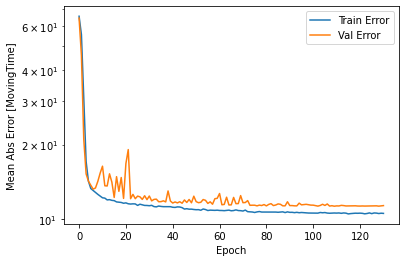

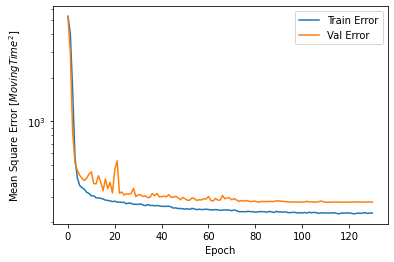

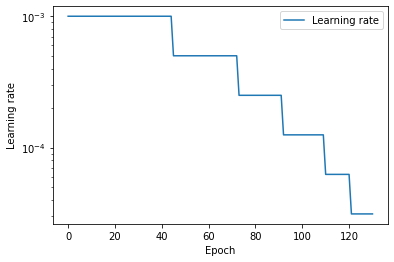

In [15]:
utils.plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

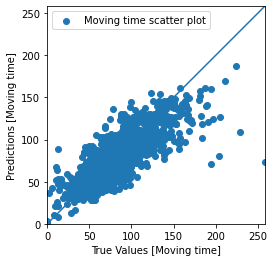

In [16]:
test_predictions = model.predict((normed_test_data, test_paths_as_array))

utils.scatter_plot(test_labels["MovingTime"].values, test_predictions, "Moving time")

It looks like our model predicts durations and moving times reasonably well, as the results should be as close to the diagonal as possible. There are interesting gaps in the plots at low times. Let's take a look at the error distribution.

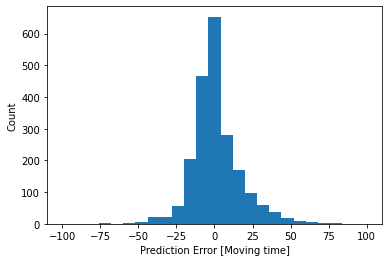

In [17]:
utils.plot_error_hist(test_labels["MovingTime"].values, test_predictions[:, 0], "Moving time")

It's not quite gaussian, but we might expect that because the number of samples is very small.

Export model for use in inference:


In [18]:
model.save('model_hikingTimePrediction_mixed.h5')

## Comparison of predictions with standard formula for predicting hiking durations

In the following, the predictions are compared with the estimates for hiking durations from a standard formula.

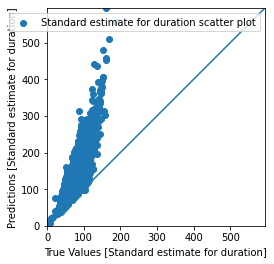

In [19]:
compute_standard_walking_time_vectorized = np.vectorize(utils.compute_standard_walking_time)

standard_estimate_walking_time = compute_standard_walking_time_vectorized(test_dataset['Length2d'].values,
                                                                          test_dataset['TotalUphill'].values,
                                                                          test_dataset['TotalDownhill'].values)

utils.scatter_plot(test_predictions[:, 0], standard_estimate_walking_time, 'Standard estimate for duration')

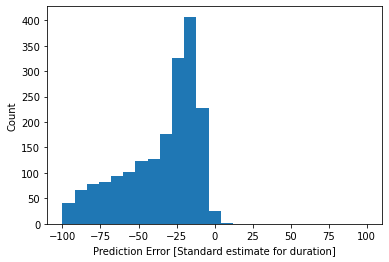

In [20]:
utils.plot_error_hist(test_predictions[:, 0], 
                      standard_estimate_walking_time, 
                      'Standard estimate for duration')

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities). The model that takes statistical features and path features as inputs performs a bit better than the other two architectures.

In [21]:
model.evaluate((normed_test_data, test_paths_as_array), test_labels, return_dict=True)

66/66 [==============================] - 1s 4ms/step - loss: 289.2513 - mean_absolute_error: 11.3106 - mean_squared_error: 289.2513


{'loss': 289.2512512207031,
 'mean_absolute_error': 11.310590744018555,
 'mean_squared_error': 289.2512512207031}